# Deliverable D4.10
## Evaluation report on the second prototype tool for the automatic semantic description of music samples

### Evaluation of "single event" algorithm

In [66]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.path.realpath("__file__")), os.pardir))
from ac_utils import freesound
import pprint
import random
import pymtg

freesound_client = freesound.FreesoundClient()
freesound_client.set_token('15dab96ed5a596aaba386b2bade17c8c5a5a68a2')

In [67]:
'''
results_pager = freesound_client.text_search(
    query="",
    filter="ac_single_event:true OR ac_single_event:false",
    fields="id,previews,ac_analysis,name",
    page_size=150,
    sort_by='rating_desc',
    group_by_pack=1,
)

all_results = []
for i in range(0, 50):
    print('Page ', i + 1)
    for sound in results_pager:
        all_results.append(sound.as_dict())
    results_pager = results_pager.next_page()
    
print(len(all_results))

import json
random.shuffle(all_results)
json.dump(all_results, open('freesound_sounds_data.json', 'w'))
'''
data = json.load(open('freesound_sounds_data.json', 'r'))
    

In [68]:
# Some util funcitons

def get_freesound_file_path(sound_id):
    pymtg.io.unicode = str  # hack to avoid problem incompatiblity in Python3
    base_path = '/mtgdb/incoming/freesound/sounds/{0}/'.format(sound_id // 1000)
    try:
        return pymtg.io.get_filenames_in_dir(dir_name=base_path, keyword='{0}_*'.format(sound_id))[0][0]
    except IndexError:
        print('No audio file for id {0} can be found. Does this sound exist?'.format(sound_id))
        return None
    
def get_freesound_embed_code(sound_id, size='small'):
    width, height = {
        'full_size': (920, 265),
        'small': (375, 30),
    }[size]
    
    return '<iframe frameborder="0" scrolling="no" src="https://freesound.org/embed/sound/iframe/{0}/simple/{1}/" width="{2}" height="{3}"></iframe>'.format(sound_id, size, width, height)

def diplay_sound_widget(sid):
    print('*', sid)
    display(Audio(get_freesound_file_path(sid)))
    

In [69]:
from IPython.display import display, Markdown, HTML, Audio
from ipywidgets import interact_manual, interact
import random
import ipywidgets as widgets
N_PER_BATCH = 50

if False:
    try:
        already_in_gt = list(json.load(open('ground_truth.json')).keys())
    except FileNotFoundError:
        already_in_gt = list()

    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            try:
                gt = json.load(open('ground_truth.json'))
            except FileNotFoundError:
                gt = {}
            gt[change['owner']._sid] = change['new']
            json.dump(gt, open('ground_truth.json', 'w'))
            already_in_gt = list(gt.keys())

    for sound in [s for s in data if str(s['id']) not in already_in_gt][:N_PER_BATCH]:
        diplay_sound_widget(sound['id'])

        buttons = widgets.RadioButtons(
            options=['skip', 'no', 'yes'],
            description='Is single event:'
        )
        buttons._sid = sound['id']
        buttons.observe(on_change)
        display(buttons)
        print('\n\n')

In [70]:
gt = json.load(open('ground_truth.json'))

tp = []  # true positive (sound is single event and detected correctly) - YAY
fp = []  # false positive (sound detected as single_event but it is not) - OUCH
tn = []  # true negative (sound detected as not single_event and it is not) - YAY
fn = []  # true positive (sound detected as not single event but it is) - OUCH

data_dict = {str(item['id']):item for item in data}

for sound_id, sound_gt in gt.items():
    if sound_gt == 'skip':
        continue
    sound = data_dict[sound_id]
    
    if sound_gt == 'yes' and sound['ac_analysis']['ac_single_event'] == True:
        tp.append(sound)
    elif sound_gt == 'no' and sound['ac_analysis']['ac_single_event'] == True:
        fp.append(sound)
    elif sound_gt == 'yes' and sound['ac_analysis']['ac_single_event'] == False:
        fn.append(sound)
    elif sound_gt == 'no' and sound['ac_analysis']['ac_single_event'] == False:
        tn.append(sound)

total = len(tp) + len(tn) + len(fp) + len(fn)
print('Size GT:', total)
print('TP:', len(tp)/total)
print('TN:', len(tn)/total)
print('FP:', len(fp)/total)
print('FN:', len(fn)/total)
print('Accuracy:', (len(tp) + len(tn))/total)




Size GT: 224
TP: 0.24553571428571427
TN: 0.39732142857142855
FP: 0.26785714285714285
FN: 0.08928571428571429
Accuracy: 0.6428571428571429


In [76]:
# Optimization of parameters for single event detection

# STEP1 : define imports and util functions

import json
import essentia
essentia.log.infoActive = False
essentia.log.warningActive = False
from essentia.standard import MonoLoader
import numpy as np
import pymtg


def estimate_number_of_events(audiofile, region_energy_thr=2, silence_thr_scale=4, group_regions_ms=100):
    """
    Returns list of activity "onsets" for an audio signal based on its energy envelope. 
    This is more like "activity detecton" than "onset detection".
    """ 

    def group_regions(regions, group_regions_ms):
        """
        Group together regions which are very close in time (i.e. the end of a region is very close to the start of the following).
        """
        if len(regions) <= 1:
            grouped_regions = regions[:]  # Don't do anything if only one region or no regions at all
        else:
            # Iterate over regions and mark which regions should be grouped with the following regions
            to_group = []
            for count, ((at0, at1, a_energy), (bt0, bt1, b_energy)) in enumerate(zip(regions[:-1], regions[1:])):
                if bt0 - at1 < group_regions_ms / 1000:
                    to_group.append(1)
                else:
                    to_group.append(0)
            to_group.append(0)  # Add 0 for the last one which will never be grouped with next (there is no "next region")

            # Now generate the grouped list of regions based on the marked ones in 'to_group'
            grouped_regions = []
            i = 0
            while i < len(to_group):
                current_group_start = None
                current_group_end = None
                x = to_group[i]
                if x == 1 and current_group_start is None:
                    # Start current grouping
                    current_group_start = i
                    while x == 1:
                        i += 1
                        x = to_group[i]
                        current_group_end = i
                    grouped_regions.append( (regions[current_group_start][0], regions[current_group_end][1], sum([z for x,y,z in regions[current_group_start:current_group_end+1]])))
                    current_group_start = None
                    current_group_end = None
                else:
                    grouped_regions.append(regions[i])
                i += 1
        return grouped_regions

    # Load audio file
    sample_rate = 44100
    audio_file = MonoLoader(filename=audiofile, sampleRate=sample_rate)
    audio = audio_file.compute()
    t = np.linspace(0, len(audio)/sample_rate, num=len(audio))
    
    # Compute envelope and average signal energy
    env_algo = essentia.standard.Envelope(
        attackTime = 15,
        releaseTime = 50,
    )
    envelope = env_algo(audio)
    average_signal_energy = np.sum(np.array(envelope)**2)/len(envelope)
    silence_thr = average_signal_energy  * silence_thr_scale
    
    # Get energy regions above threshold
    # Implementation based on https://stackoverflow.com/questions/43258896/extract-subarrays-of-numpy-array-whose-values-are-above-a-threshold
    mask = np.concatenate(([False], envelope > silence_thr, [False] ))
    idx = np.flatnonzero(mask[1:] != mask[:-1])
    idx -= 1  # Avoid index out of bounds (0-index)
    regions = [(t[idx[i]], t[idx[i+1]], np.sum(envelope[idx[i]:idx[i+1]]**2)) for i in range(0, len(idx), 2)]  # Energy is a list of tuples like (start_time, end_time, energy)
    regions = [region for region in regions if region[2] > region_energy_thr] # Discard those below region_energy_thr
    
    # Group detected regions that happen close together
    regions = group_regions(regions, group_regions_ms)            

    return len(regions)  # Return number of sound events detected


def get_freesound_file_path(sound_id):
    pymtg.io.unicode = str  # hack to avoid problem incompatiblity in Python3
    base_path = '/mtgdb/incoming/freesound/sounds/{0}/'.format(sound_id // 1000)
    try:
        return pymtg.io.get_filenames_in_dir(dir_name=base_path, keyword='{0}_*'.format(sound_id))[0][0]
    except IndexError:
        print('No audio file for id {0} can be found. Does this sound exist?'.format(sound_id))
        return None
    
    
def get_analysis_params_key(region_energy_thr, silence_thr_scale, group_regions_ms, max_duration):
    return '{0}-{1}-{2}-{3}'.format(region_energy_thr, silence_thr_scale, group_regions_ms, max_duration)
    

In [72]:
# STEP 2: define variables

gt = {sound_id: sound_gt for sound_id, sound_gt in json.load(open('ground_truth.json')).items() if sound_gt != 'skip'}

In [87]:
analysis_results = {}

In [117]:
# STEP 3: run analysis

#analysis_results = json.load(open('analysis_results_0_8_0_8_0_200_1.json'))


wp = pymtg.processing.WorkParallelizer()

def analyze(sound_id, anlalysis_params_key, sound_path, region_energy_thr, silence_thr_scale, group_regions_ms, max_duration):
    n_audio_events = estimate_number_of_events(sound_path, region_energy_thr, silence_thr_scale, group_regions_ms)
    duration = len(MonoLoader(filename=sound_path, sampleRate=44100).compute())/44100
    
    single_event = n_audio_events == 1
    if single_event and max_duration is not None:
        if duration > max_duration:
            single_event = False
            
    return (sound_id, anlalysis_params_key, single_event)

for (region_energy_thr, silence_thr_scale, group_regions_ms) in [(2, 4, 100), (0.5, 4.5, 50)]:
    for max_duration in [11, 12, 13, 14, 15, 16]:#np.arange(5, 10, 1):
        for sound_id, sound_gt in gt.items():
            sound_path = get_freesound_file_path(int(sound_id))
            anlalysis_params_key = get_analysis_params_key(region_energy_thr, silence_thr_scale, group_regions_ms, max_duration)
            if anlalysis_params_key not in analysis_results[sound_id]:
                wp.add_task(analyze, sound_id, anlalysis_params_key, sound_path, region_energy_thr, silence_thr_scale, group_regions_ms, max_duration)
                
wp.run(num_workers=4)

# Show errors after computing all tasks (if any)
if wp.num_tasks_failed > 0:
    wp.show_errors()
    
# Store results in analysis dict
for t in wp.tasks_succeeded():
    sound_id, anlalysis_params_key, result = t.result()
    if sound_id not in analysis_results:
        analysis_results[sound_id] = {}
    analysis_results[sound_id][anlalysis_params_key] = result


Submitting 2688 tasks to 4 workers
[2688/2688, 0 running] 0:00:00 remainingremainingggggg
All tasks compelted! [2688 succeeded, 0 failed]


In [118]:
# STEP 4: compute evaluation metrics

accuracies = list()

for anlalysis_params_key in list(analysis_results.values())[0].keys():
    
    tp = []  # true positive (sound is single event and detected correctly) - YAY
    fp = []  # false positive (sound detected as single_event but it is not) - OUCH
    tn = []  # true negative (sound detected as not single_event and it is not) - YAY
    fn = []  # true positive (sound detected as not single event but it is) - OUCH
    
    for sound_id, sound_gt in gt.items():
        result = analysis_results[sound_id][anlalysis_params_key]

        if sound_gt == 'yes' and result == True:
            tp.append(sound_id)
        elif sound_gt == 'no' and result == True:
            fp.append(sound_id)
        elif sound_gt == 'yes' and result == False:
            fn.append(sound_id)
        elif sound_gt == 'no' and result == False:
            tn.append(sound_id)

    total = len(tp) + len(tn) + len(fp) + len(fn)
    accuracies.append((anlalysis_params_key, (len(tp) + len(tn))/total))
    
    if False:
        print(anlalysis_params_key)
        print('- Size GT:', total)
        print('- TP:', len(tp)/total)
        print('- TN:', len(tn)/total)
        print('- FP:', len(fp)/total)
        print('- FN:', len(fn)/total)
        print('- Accuracy:', (len(tp) + len(tn))/total)
        print('')
        
    if False:
        for sound_id in fp[0:5]:
            diplay_sound_widget(int(sound_id))
        
    

print('\nSUMMARY:')
for name, accuracy in sorted(accuracies, key=lambda x: x[1], reverse=True)[0:40]:
    print(name, '\t', accuracy)


SUMMARY:
0.5-4.5-50-7 	 0.8169642857142857
0.5-4.5-50-8 	 0.8125
0.5-4.5-50-5 	 0.8080357142857143
0.5-4.5-50-6 	 0.8080357142857143
0.5-4.5-50-9 	 0.7991071428571429
2-4-100-5 	 0.7901785714285714
0.5-4.5-50-10 	 0.7901785714285714
2-4-100-7 	 0.7857142857142857
2-4-100-6 	 0.78125
2-4-100-8 	 0.7767857142857143
0.5-4.5-50-2 	 0.7767857142857143
0.5-4.5-50-3 	 0.7767857142857143
0.5-4.5-50-11 	 0.7767857142857143
2-4-100-2 	 0.7723214285714286
0.5-4.5-50-12 	 0.7723214285714286
2-4-100-9 	 0.7678571428571429
0.5-4.5-50-13 	 0.7678571428571429
2-4-100-3 	 0.7633928571428571
0.5-4.5-50-14 	 0.7633928571428571
2-4-100-10 	 0.7589285714285714
0.5-4.5-50-15 	 0.7589285714285714
0.5-4.5-50-16 	 0.7544642857142857
2-4-100-11 	 0.7455357142857143
2-4-100-12 	 0.7366071428571429
2-4-100-13 	 0.7321428571428571
0.5-4.5-50-1 	 0.7276785714285714
2-4-100-14 	 0.7276785714285714
2-4-100-15 	 0.7232142857142857
2-4-100-1 	 0.71875
2-4-100-16 	 0.71875
0.5-4.5-50-None 	 0.6875
2-4-100-None 	 0.6428

# Info for deliverable:

Previous method:
2-4-100-None
- Size GT: 224
- TP: 0.24553571428571427
- TN: 0.39732142857142855
- FP: 0.26785714285714285
- FN: 0.08928571428571429
- Accuracy: 0.6428571428571429

Method with optimized parameters:
0.5-4.5-50-None
- Size GT: 224
- TP: 0.24107142857142858
- TN: 0.44642857142857145
- FP: 0.21875
- FN: 0.09375
- Accuracy: 0.6875

Method filtering by duration:
0.5-4.5-50-7
- Size GT: 224
- TP: 0.21875
- TN: 0.5982142857142857
- FP: 0.06696428571428571
- FN: 0.11607142857142858
- Accuracy: 0.8169642857142857



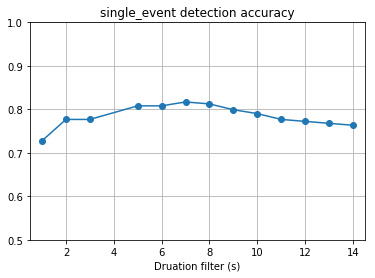

In [122]:
accuracies_with_filter = [] #[0.8080357142857143, 0.8080357142857143, 0.8169642857142857, 0.8125, 0.7991071428571429, 0.7901785714285714]
durations = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for duration in durations:
    for acc in accuracies:
        if acc[0] == '0.5-4.5-50-{0}'.format(duration):
            accuracies_with_filter.append(acc[1])
            break

import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(durations, accuracies_with_filter, marker='o')
plt.title('single_event detection accuracy')
plt.xlabel('Druation filter (s)')
plt.axis([0.5, 14.5, 0.5, 1])
plt.grid(True)
plt.show()